Start Training...
Epoch [0/5] Batch 0/1583             Loss D: 1.8046, Loss G: 4.9243, D(x)=0.3914, D(G(z))=0.4061 / 0.0101
Epoch [0/5] Batch 100/1583             Loss D: 0.5052, Loss G: 6.2495, D(x)=0.8417, D(G(z))=0.0108 / 0.0022
Epoch [0/5] Batch 200/1583             Loss D: 0.8851, Loss G: 2.6134, D(x)=0.5764, D(G(z))=0.0642 / 0.0997
Epoch [0/5] Batch 300/1583             Loss D: 1.3629, Loss G: 2.4611, D(x)=0.4632, D(G(z))=0.1968 / 0.1378
Epoch [0/5] Batch 400/1583             Loss D: 1.5765, Loss G: 1.9226, D(x)=0.4705, D(G(z))=0.4273 / 0.1878
Epoch [0/5] Batch 500/1583             Loss D: 1.2780, Loss G: 1.4879, D(x)=0.3735, D(G(z))=0.1291 / 0.2772
Epoch [0/5] Batch 600/1583             Loss D: 1.1510, Loss G: 1.4055, D(x)=0.4527, D(G(z))=0.2063 / 0.2813
Epoch [0/5] Batch 700/1583             Loss D: 1.2724, Loss G: 1.7706, D(x)=0.4811, D(G(z))=0.2963 / 0.2031
Epoch [0/5] Batch 800/1583             Loss D: 1.1777, Loss G: 3.0264, D(x)=0.6729, D(G(z))=0.4297 / 0.0756
Epoch [0/5] 

Epoch [4/5] Batch 1200/1583             Loss D: 1.0105, Loss G: 2.5344, D(x)=0.6942, D(G(z))=0.3970 / 0.0923
Epoch [4/5] Batch 1300/1583             Loss D: 1.0541, Loss G: 1.9931, D(x)=0.7592, D(G(z))=0.4429 / 0.1568
Epoch [4/5] Batch 1400/1583             Loss D: 1.1207, Loss G: 1.2805, D(x)=0.4291, D(G(z))=0.2089 / 0.3084
Epoch [4/5] Batch 1500/1583             Loss D: 1.1419, Loss G: 2.3889, D(x)=0.6707, D(G(z))=0.4548 / 0.1030


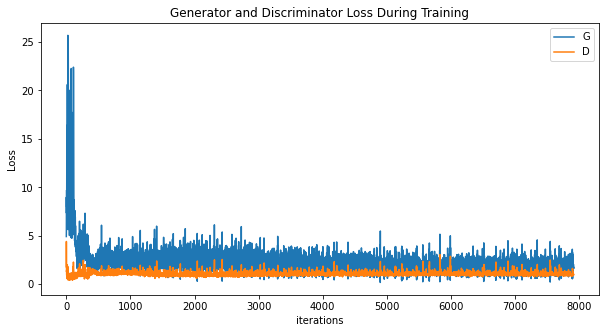

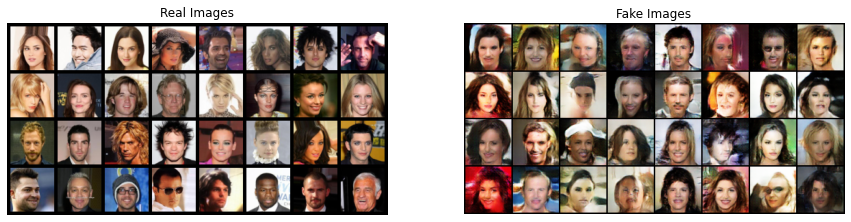

In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#To run on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Defining Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
        # N x channels_img x 64 x 64
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        # N x features_d x 32 x 32
        nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(features_d*2),
        nn.LeakyReLU(0.2),
        # N x features_d*2 x 16 x 16
        nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(features_d*4),
        nn.LeakyReLU(0.2),
        # N x features_d*4 x 8 x 8
        nn.Conv2d(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(features_d*8),
        nn.LeakyReLU(0.2),
        # N x features_d*8 x 4 x 4   
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=0),
        # N x 1 x 1 x 1  
        nn.Sigmoid()       
        )
        
        
    def forward(self,x):
        return self.net(x)
    
# Defining Generator
    
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
        # N x channels_noise x 1 x 1
        nn.ConvTranspose2d(channels_noise, features_g*16, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(features_g*16),
        nn.ReLU(),
        # N x features_g*16 x 4 x 4
        nn.ConvTranspose2d(features_g*16, features_g*8, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(features_g*8),
        nn.ReLU(),
        # N x features_g*8 x 8 x 8
        nn.ConvTranspose2d(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(features_g*4),
        nn.ReLU(),
        # N x features_g*4 x 16 x 16
        nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(features_g*2),
        nn.ReLU(),
        # N x features_g*2 x 32 x 32
        nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
        # N x channels_img x 64 x 64   
        )
        
    def forward(self,x):
        return self.net(x)
    
    
#Hyperparameters

# Root directory for dataset
dataroot = "data/celeba"

lr=0.0002
batch_size=128
image_size=64 #28x28 --> 64x64
channels_img=3
channels_noise=256
num_epochs=5
features_d=64
features_g=64

dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

#Dataset
dataloader= DataLoader(dataset, batch_size=batch_size, shuffle=True)


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#create discriminator and generator
netD = Discriminator(channels_img, features_d).to(device)
netG = Generator(channels_noise, channels_img, features_g).to(device)

#initial weights
netG.apply(weights_init)
netD.apply(weights_init)


#setup optimizer for discriminator and generator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

#Train Mode
netD.train()
netG.train()

#Loss function
criterion = nn.BCELoss()

#Labels
real_label=1
fake_label=0

fixed_noise = torch.randn(64, channels_noise, 1, 1).to(device)
writer_real = SummaryWriter(f'runs/GAN_Celeb/test_real')
writer_fake = SummaryWriter(f'runs/GAN_Celeb/test_fake')

print('Start Training...')

G_losses = []
D_losses = []
img_list = []
iters = 0


for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(dataloader):
        data = data.to(device)
        data_size= data.shape[0]
    
        ### Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        label = (torch.ones(data_size)*0.9).to(device)
        output = netD(data).reshape(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()


        noise = torch.randn(data_size, channels_noise, 1, 1).to(device)
        fake = netG(noise)
        label = (torch.zeros(data_size)*0.1).to(device)

        output= netD(fake.detach()).reshape(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        
        lossD = lossD_real + lossD_fake
        #lossD.backward()
        optimizerD.step()
    
        ### Train Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label = torch.ones(data_size).to(device)
        output = netD(fake).reshape(-1) # LOOK Here
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # To display the network's performance on tensorboard
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
            Loss D: {lossD:.4f}, Loss G: {lossG:.4f}, D(x)={D_x:.4f}, D(G(z))={D_G_z1:.4f} / {D_G_z2:.4f}')

            with torch.no_grad():
                fake = netG(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(data[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                writer_real.add_image('Real Image', img_grid_real)
                writer_fake.add_image('Fake Image', img_grid_fake)
                
        # Save Losses for plotting later
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake[:32], padding=2, normalize=True))
            
        iters += 1
                        
                        
# Losses                        
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(data.to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

